In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/spaceship-titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

In [3]:
def proc_data(df):
    df['RoomService'] = df.RoomService.fillna(0)
    df['FoodCourt'] = df.FoodCourt.fillna(0)
    df['ShoppingMall'] = df.ShoppingMall.fillna(0)
    df['Spa'] = df.Spa.fillna(0)
    df['VRDeck'] = df.VRDeck.fillna(0)
    df.fillna(modes, inplace=True)
    df['VIP'] = pd.Categorical(df.VIP)
    df['CryoSleep'] = pd.Categorical(df.CryoSleep)
    df['HomePlanet'] = pd.Categorical(df.HomePlanet)
    df['Destination'] = pd.Categorical(df.Destination)
    
    df['CabinDeck'] = df.Cabin.str[0]
    df['CabinSide'] = df.Cabin.str[-1]
    df['GroupId'] = df.PassengerId.str.split('_', expand=True)[0]
    df['GroupSize'] = df.groupby('GroupId')['GroupId'].transform('count')
    df['Alone'] = df.GroupSize==1
    df['Alone'] = pd.Categorical(df.Alone)
    df['CabinDeck'] = pd.Categorical(df.CabinDeck)
    df['CabinSide'] = pd.Categorical(df.CabinSide)

proc_data(df)
df['Transported'] = df.Transported.astype(int)

proc_data(tst_df)

In [4]:
cats=["HomePlanet","Destination", 'CryoSleep', 'VIP', 'Alone', "CabinDeck", "CabinSide"]
conts=['Age', 'RoomService',"FoodCourt", "ShoppingMall", "Spa", "VRDeck", "GroupSize"]
dep="Transported"

In [5]:
df.CabinDeck.head()

0    B
1    F
2    A
3    A
4    F
Name: CabinDeck, dtype: category
Categories (8, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

In [6]:
df.CabinDeck.cat.codes.head()

0    1
1    5
2    0
3    0
4    5
dtype: int8

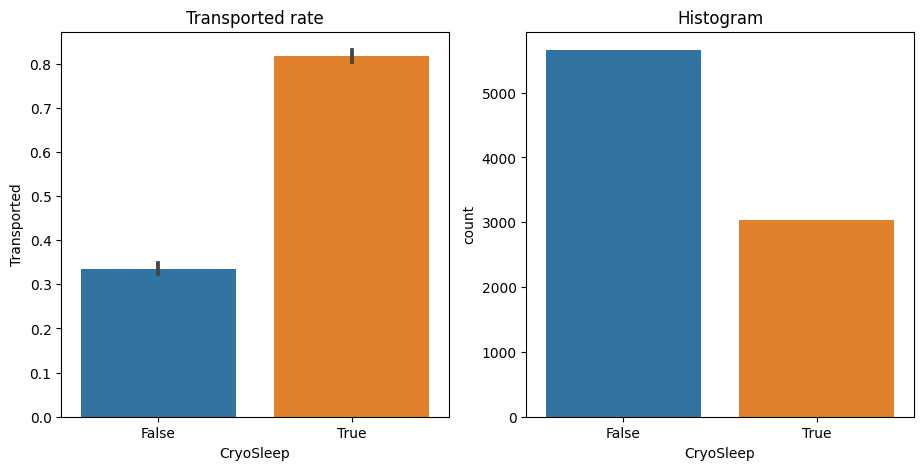

In [7]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="CryoSleep", ax=axs[0]).set(title="Transported rate")
sns.countplot(data=df, x="CryoSleep", ax=axs[1]).set(title="Histogram");

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [10]:
preds = val_xs.CryoSleep==1

In [11]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.2755289788408464

In [12]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [13]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [14]:
score(trn_xs["CryoSleep"], trn_y, 0.5)

0.4427274084379482

In [15]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'RoomService', 'FoodCourt', 'ShoppingMall', '…

In [16]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Al…

In [17]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(5.0, 0.49588222217088634)

In [19]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'HomePlanet': (0, 0.49262732535926257),
 'Destination': (0, 0.4975146234286769),
 'CryoSleep': (0, 0.4427274084379482),
 'VIP': (0, 0.4997003165253164),
 'Alone': (0, 0.49698224841136424),
 'CabinDeck': (2, 0.49146596918858604),
 'CabinSide': (0, 0.4972039930912765),
 'Age': (5.0, 0.49588222217088634),
 'RoomService': (0.0, 0.4712139445780011),
 'FoodCourt': (0.0, 0.4864171323280328),
 'ShoppingMall': (0.0, 0.4838374399256237),
 'Spa': (0.0, 0.46960050421496596),
 'VRDeck': (0.0, 0.47094236980183707),
 'GroupSize': (1, 0.49698224841136424)}

## Creating a decision tree

In [20]:
cols.remove("CryoSleep")
is_cryo_sleep = trn_df.CryoSleep==1
cryo,not_cryo = trn_df[is_cryo_sleep],trn_df[~is_cryo_sleep]

In [21]:
{o:min_col(cryo, o) for o in cols}

{'HomePlanet': (0, 0.3324940920248624),
 'Destination': (0, 0.3740458872508508),
 'VIP': (0, 0.3837817238636689),
 'Alone': (0, 0.3827698578497132),
 'CabinDeck': (5, 0.33552647892408066),
 'CabinSide': (0, 0.3822152342183273),
 'Age': (25.0, 0.38204553257058477),
 'RoomService': (0.0, 0.38524640908573105),
 'FoodCourt': (0.0, 0.38524640908573105),
 'ShoppingMall': (0.0, 0.38524640908573105),
 'Spa': (0.0, 0.38524640908573105),
 'VRDeck': (0.0, 0.38524640908573105),
 'GroupSize': (1, 0.3827698578497132)}

In [22]:
{o:min_col(not_cryo, o) for o in cols}

{'HomePlanet': (0, 0.4726119049767322),
 'Destination': (0, 0.47260926249874624),
 'VIP': (1, 0.4730642283444852),
 'Alone': (0, 0.47117947914539726),
 'CabinDeck': (2, 0.4700344909647713),
 'CabinSide': (0, 0.4698411317877338),
 'Age': (12.0, 0.46380962227595895),
 'RoomService': (345.0, 0.4585999894343045),
 'FoodCourt': (1330.0, 0.4632830161736957),
 'ShoppingMall': (626.0, 0.46541478497591),
 'Spa': (455.0, 0.45865870936480796),
 'VRDeck': (4088.0, 0.4640202339045242),
 'GroupSize': (2, 0.47062646352776444)}

In [23]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [24]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

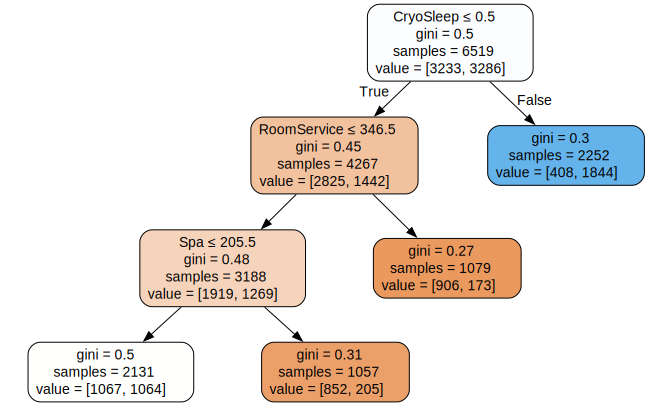

In [25]:
draw_tree(m, trn_xs, size=10)

In [26]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2755289788408464

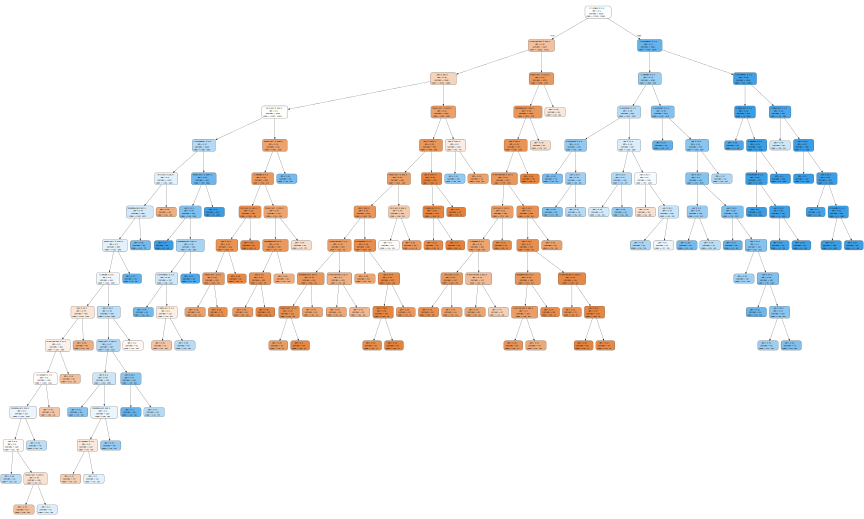

In [27]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [28]:
mean_absolute_error(val_y, m.predict(val_xs))

0.20975160993560257

In [29]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Transported'] = (preds == 1)
    sub_df = tst_df[['PassengerId','Transported']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

## The random forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.20883164673413063

In [31]:
subm(rf.predict(tst_xs), 'rf')

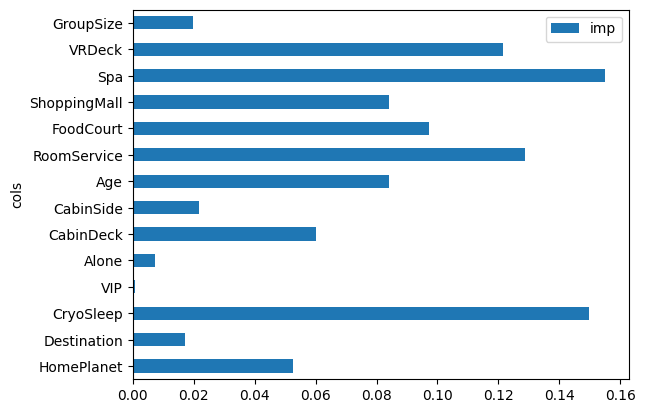

In [32]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');